## 项目简介

In [1]:
#导入tensorflow
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

**1.导入数据。在这里，我使用tfds中的imdb_reviews数据集(这里选用的是子词数目为8k的版本)。**

In [2]:
'''
tfds.load(name,split,with_info,as_supervied)常用参数解释：

1. name：是字符串，可以是”dataset_name(数据集名)，也可以是“/filepath/dataset_name”(数据路径名),总之必须是字符串；
2. split：split表示希望数据切分的结果，一般就是切分为训练集与测试集，(tfds.Split.TRAIN,tfds.Split.TEST);
3. with_info：为True，表示打印出与数据集相关的信息：特征名，数量，来源等等，
   返回的是tuple:(tf.data.Dataset, tfds.core.DatasetInfo)；为False，不打印;
4. as_supervised：为True，表示将切分的训练集与测试集都表示为(feature,label)；为False，表示输出的训练集与测试集是包含所有特征的字典.

来源：https://tensorflow.google.cn/datasets/api_docs/python/tfds/load#args
'''

'''
(train_data,test_data):训练集，测试集
info：与数据集相关的信息
'''
(train_data,test_data),info=tfds.load("imdb_reviews/subwords8k",
                                     split=(tfds.Split.TRAIN,tfds.Split.TEST),
                                     with_info=True,
                                     as_supervised=True)

In [3]:
#打印info,可以看到与数据集相关的信息
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [4]:
encoder=info.features["text"].encoder
#打印前10个子词，譬如：“a_”，其中_表示空格
print(encoder.subwords[:10])
#打印子词的总数量
print(encoder.subwords.__len__())
#打印词汇表的数量，这里需要注意，词汇表的数量比子词数量多，这是因为在词汇表中，还存在一些用来构建其他单词的词根
print(encoder.vocab_size)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br']
7928
8185


In [5]:
#使用padded_batch方法来标准化评论的长度
padded_shapes=([None],())
train_batchs=train_data.shuffle(1024).padded_batch(128,padded_shapes=padded_shapes)
test_batchs=test_data.shuffle(1024).padded_batch(10,padded_shapes=padded_shapes)

In [6]:
# 样本都被padding到了每一批中最长的样本长度
train_batch,train_label=next(iter(train_batchs))
train_batch.numpy(),train_batch.numpy().shape
print(train_batch.shape)

(128, 1109)


### 创建CBOW模型


In [7]:
embedding_dim=256
model=tf.keras.Sequential([
    layers.Embedding(encoder.vocab_size,embedding_dim),
    layers.GlobalAveragePooling1D(),
    # 删除这一层，模型更加简单，获得的词向量更具有解释性
#     layers.Dense(16,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2095360   
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 2,095,617
Trainable params: 2,095,617
Non-trainable params: 0
_________________________________________________________________


In [8]:
#构建网络架构
embedding_size=256

inputs=tf.keras.Input(shape=(train_batch.shape[1],))
h1=layers.Embedding(input_dim=encoder.vocab_size,output_dim=embedding_size)(inputs)
h1=layers.GlobalAveragePooling1D()(h1)
outputs=layers.Dense(1,activation="sigmoid")(h1)

model=tf.keras.Model(inputs=inputs,outputs=outputs)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1109)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1109, 256)         2095360   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,095,617
Trainable params: 2,095,617
Non-trainable params: 0
_________________________________________________________________


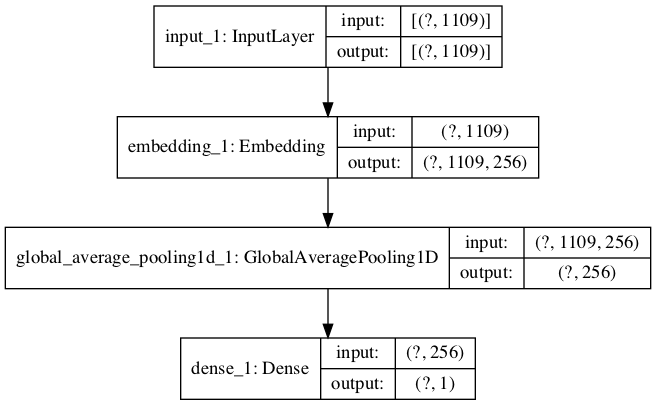

In [9]:
#打印模型架构
model.summary()
tf.keras.utils.plot_model(model,"cbow_model.png",show_shapes=True)

In [10]:
#注意，我是在colab上跑的模型，然后将权重下载下来，因为mac上没有cuda(😭)
#如果你自己的机器上可以跑的话，那么直接就可以了
if os.path.exists("./word_embedding/weights"+".index"):
    print("we will load model!")
    model.load_weights("./word_embedding/weights")
else:
    #定义callbacks
    callbacks=tf.keras.callbacks.ModelCheckpoint(filepath="./word_embedding/worr_embedding.ckpt",
                                                save_weights_only=True)
    #训练模型
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    history=model.fit(train_batchs,validation_data=test_batchs,epochs=8,callbacks=[callbacks])

we will load model!


## 获取训练好的词向量

In [11]:
# 词向量的维度是（vocab_size,embeddind_dim)
embedding=model.layers[1]
print(embedding)
weights=embedding.get_weights()[0]
print(weights.shape)
# # shape: (vocab_size, embedding_dim)

(8185, 256)


In [12]:
# 将得到的词向量与对于单词保存到文本中
# 以下代码来自于官方教程，但是我认为这是错误的
# 以至于之后我找最后最接近的10个单词结果很诡异
# 词汇表中第一个单词是'the_'
# 时间上这个单词对应的编码是[181, 8024]
# 单词the对应的是 181，‘_'对应8024
# 这样也就可以解释subwords只有7928个，voabsize是8025
# 当然，以上只是我个人想法，也许我没有理解官方教程的意思

vecs=[]
import io
encoder=info.features['text'].encoder
out_v=io.open('word_embedding/vecs.tsv','w',encoding='utf-8')
out_m=io.open('word_embedding/meta.tsv','w',encoding='utf-8')
for num, word in enumerate(encoder.subwords):
#     vec = weights[num+1] # skip 0, it's padding.
    # 注释掉的是官方教程中的,下面是我认为正确的
    if(num==110):
        print(word)
    vec=weights[encoder.encode(word)]
    if num==1:
        print(vec,vec.shape)
    if len(vec)==1:
        vecs.append(vec)
    out_m.write(word + "\n")#保存子词
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")#保存每个子词所对应的embedding
out_v.close()
out_m.close()

[[ 0.03674514  0.03667488  0.01724854  0.05671534 -0.03932721  0.03601478
  -0.00119376  0.02926619  0.03596869  0.00332739 -0.01752954  0.04279882
  -0.01265101 -0.02364092 -0.02796109 -0.02059811 -0.04058252  0.01984459
  -0.04853086  0.0204135   0.04166331  0.01895269 -0.05226582 -0.02615745
  -0.01883722 -0.02309862 -0.00903557 -0.03964091  0.0397741  -0.00400699
  -0.03473621  0.0233261  -0.03468351  0.03619903  0.02688707  0.01521487
   0.04015989  0.02046127 -0.04891264 -0.00283322  0.07034566  0.04100341
  -0.04144504  0.03712101 -0.02132559  0.00271413  0.0252488   0.00435524
  -0.02670787 -0.01344186  0.01526742  0.03075549  0.02627658  0.02251604
   0.04783022 -0.00376078  0.00991804 -0.02180438 -0.02694117  0.00776211
  -0.03234079  0.00728674 -0.00471138 -0.01573562  0.02995441 -0.05567717
   0.00389069  0.05353813 -0.0701056   0.01811667 -0.02927376  0.02138192
   0.03708767 -0.00527796 -0.00089927  0.0104067  -0.0224056   0.03928775
  -0.06097449 -0.01973315  0.00641546 

In [13]:
len(encoder.subwords),encoder.vocab_size #encoder中遍历单词个数与vocab_size不一致
# 原因是 subwords包含的是单词以及部分词根，而词汇表中包含了一些符号，如'_',','等等

(7928, 8185)

In [42]:
class Similarity(object):
    def __init__(self):
        super(Similarity,self).__init__()

   # 计算两个词向量的距离
    def cal_eul_distance(self,x1,x2):
        return np.sqrt(np.sum(np.square(x1-x2)))

    
    # 构建距离矩阵
    def build_distance_matrix(self,x):
        matrix=np.zeros((len(x),len(x)))
        for i in range(len(x)):
            for j in range(i,len(x)):
                distance=self.cal_eul_distance(x[i],x[j])
                matrix[i][j]=distance
                matrix[j][i]=distance
        return matrix
    
    # 获得单词与其对应的索引
    def get_index_and_word(self,encoder):
        vocabulary=[]
        for word in encoder.subwords:
            if word[-1]=='_' or word[-1]==' ':
                word=word[:-1] #去掉最后的‘_'
            # 这个index才是单词在embedding层中真正对应的index
            index=encoder.encode(word)
            vocabulary.append((index,word))
        return vocabulary

    def find_top_K(self,matrix,index,K):
        dis=matrix[index] # 获得了测试单词词向量到所有单词词向量的距离

        #下面我们需要找到distances中最小的k个元素，并且返回他们的索引就可以了
        # argsort函数返回的是数组值从小到大的索引值
        # 将distances变为np.array，然后对索引排序，取前k个
        minK=np.argsort(np.array(dis))[:K]
        print(minK)
        result=[]
        for i in range(K):
            result.append(words[minK[i]])
        return result

In [43]:
a=Similarity()

In [40]:
# 包含了（index，word）其中index是embeding层中对应的index
vocab=a.get_index_and_word(encoder)#获取
index,word=vocab[0]
print(index)
print(word)
print(vocab.__len__())


vec=[]#保存每个token的embedding
words=[]#保存所有的token
# 下面依据index构建词向量矩阵与单词矩阵
for (index,word) in vocab:
    #  注意有些词是合成的，所以有多个index，对于这些词，就不管了
    if len(index)==1 and word not in words:
        vec.append(weights[index[0]])
        words.append(word)
print(len(vec))
print(words[0],words.index("the"))
words.index('good'),words.index('bad'),words.index('nice')
# 测试一下 good 与 nice，应该很接近
# good与bad很远
# 欧式距离
print(f'distance between {words[68]} and {words[121]} is {a.cal_eul_distance(vec[68],vec[121])})')
print(f'distance between {words[68]} and {words[355]} is {a.cal_eul_distance(vec[68],vec[355])})')

print(words[68],words[355],words[121])


[181]
the
7928
5375
the 0
distance between good and bad is 20.785064697265625)
distance between good and nice is 9.08594036102295)
good nice bad


In [22]:
D=a.build_distance_matrix(vec)

In [28]:

test_word='beautiful'
test_index=words.index(test_word)
test_index,vec[test_index]

(357,
 array([-0.81756485,  0.8845696 ,  0.7981111 ,  0.88830745, -0.7718989 ,
        -0.7743183 ,  0.8282609 ,  0.8156345 ,  0.76640636,  0.8987174 ,
         0.8452093 ,  0.829567  ,  0.7258168 , -0.8346607 , -0.8645079 ,
         0.78254247, -0.8240878 ,  0.838096  , -0.86232865, -0.77565986,
         0.7549031 ,  0.80530006, -0.8692067 , -0.7586058 ,  0.8231848 ,
        -0.80219203,  0.8046923 , -0.80172473, -0.8299744 ,  0.82461894,
        -0.7439966 ,  0.8448385 ,  0.74287933,  0.8472642 ,  0.826696  ,
         0.79085034, -0.8653219 ,  0.8494416 , -0.9021968 ,  0.827109  ,
         0.8458385 ,  0.77066934, -0.7798099 , -0.8037085 , -0.7833666 ,
         0.73181105, -0.7848915 , -0.84284276, -0.78433067,  0.79069656,
        -0.7979986 ,  0.73162335, -0.731095  ,  0.8671764 ,  0.8721723 ,
         0.8376888 ,  0.72624046,  0.76385957,  0.8036252 , -0.74609613,
         0.8184952 , -0.72099394, -0.79891574,  0.81171143,  0.81777495,
        -0.8522996 , -0.77029884,  0.7602869 

In [44]:
result=a.find_top_K(D,test_index,8)
print(f"target word:{[test_word]} -> top8 words:{result}")

[ 357 4980 4691 1757 3705 2346 1182 4991]
target word:['beautiful'] -> top8 words:['beautiful', 'Carre', 'extraordinar', 'surprise', 'lonel', 'delight', 'enjoyable', 'sensitive']
